## **Pre-Processing**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import gc
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [0]:
ratings = pd.read_csv('/content/drive/My Drive/DS Project 20M/ratings.csv')

In [0]:
movies = pd.read_csv('/content/drive/My Drive/DS Project 20M/movies.csv')

In [0]:
total=ratings.merge(movies,on='movieId',how='inner')
total['genres']=total['genres'].apply(lambda x: x.split('|'))

In [0]:
test=pd.DataFrame(total.groupby(['userId']).agg(movie_count=pd.NamedAgg(column='movieId', aggfunc='count')))

In [0]:
test = test.sort_values('movie_count',ascending=False)

In [0]:
test.describe()

In [0]:
test = test[test['movie_count'] > 200]

In [0]:
test = test.reset_index()

In [0]:
test

In [0]:
total=total.merge(test,on='userId',how='inner')

In [0]:
total.drop(columns = ['movie_count'], inplace = True)

In [0]:
total

In [0]:
total.describe()['timestamp']['75%']

1455488882.0

In [0]:
temp = total[['userId','movieId','timestamp']]

In [0]:
temp1 = temp.copy()

In [0]:
temp1

In [0]:
temp1['class'] = temp1['timestamp'].apply(lambda x: 1 if x < 1455488882.0 else 2)

In [0]:
temp1

In [0]:
del ratings

In [0]:
gc.collect()

28

In [0]:
temp1 = temp1.groupby(['userId','class'])['movieId'].count()

In [0]:
temp1

In [0]:
temp1 = temp1.reset_index(level=[1])

In [0]:
temp1 = temp1.groupby(level = 0).count()

In [0]:
active_users = temp1[temp1['class'] == 2].index.tolist()

In [0]:
del test,temp1
gc.collect()

0

In [0]:
gc.collect()

0

## **User Movie Matrix**

In [0]:
active_users = pd.read_csv('/content/drive/My Drive/DS Project 20M/ActiveUsers.csv')

In [0]:
total = total[total.userId.isin(active_users['userId'].tolist())]

In [8]:
total

,userId,movieId,rating,timestamp,title,genres
1,3,296,5.0,1439474476,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
12,19,296,3.5,1466674637,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
90,187,296,4.5,1277374442,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
140,284,296,4.5,1431924674,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
173,357,296,3.5,1367156671,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
...,...,...,...,...,...,...
25000073,162067,203064,2.5,1560035272,The Hotshots (1968),[Comedy]
25000074,162271,92648,3.0,1327978630,BookWars (2000),"[Comedy, Crime, Documentary]"
25000075,162271,92946,1.0,1329627154,"Souler Opposite, The (1998)","[Comedy, Romance]"
25000076,162271,95230,2.5,1340566357,Macbeth in Manhattan (1999),[Drama]


In [0]:
movie_ids = pd.read_csv('/content/drive/My Drive/DS Project 20M/ActiveMovies.csv')

In [0]:
movies_temp = movies[movies.movieId.isin(movie_ids['movieId'].tolist())]

In [0]:
movies_temp['genres']=movies_temp['genres'].apply(lambda x: x.split('|'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
movies_temp

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
62406,209131,Last Days of the Arctic (2011),[Documentary]
62414,209147,The Carpet of Horror (1962),"[Crime, Horror]"
62415,209151,Mao Zedong 1949 (2019),[(no genres listed)]
62419,209159,Window of the Soul (2001),[Documentary]


In [0]:
import itertools
genres_count = list(itertools.chain(*movies_temp.genres.tolist()))

In [0]:
import collections
genres_dict = collections.Counter(genres_count)

In [0]:
genres_dict

Counter({'(no genres listed)': 3519,
         'Action': 6010,
         'Adventure': 3432,
         'Animation': 2464,
         'Children': 2445,
         'Comedy': 14033,
         'Crime': 4561,
         'Documentary': 4900,
         'Drama': 22251,
         'Fantasy': 2405,
         'Film-Noir': 348,
         'Horror': 4960,
         'IMAX': 194,
         'Musical': 983,
         'Mystery': 2520,
         'Romance': 6515,
         'Sci-Fi': 3139,
         'Thriller': 7388,
         'War': 1650,
         'Western': 985})

In [0]:
user_movie = pd.merge(active_users, ratings, left_on = 'userId', right_on = 'userId')

In [0]:
movie_matrix = user_movie.pivot_table(index='userId',columns='movieId',values='rating')

In [0]:
movie_matrix = movie_matrix.fillna(0.0)

In [0]:
X = movie_matrix.iloc[:, :].values

## **Hierarchical Clustering**

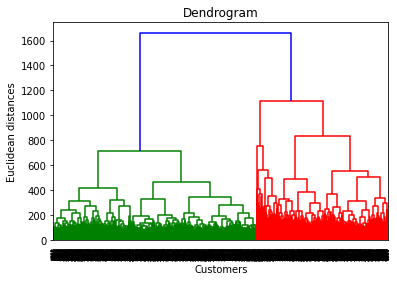

In [0]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [0]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)

In [0]:
y_hc

In [0]:
xyz = pd.concat([active_users, pd.DataFrame(y_hc)], axis = 1)
xyz = xyz.rename(columns = {0: 'Cluster'})
xy = xyz.iloc[:, :].values

In [0]:
import collections
collections.Counter(y_hc)

## **Cluster 1**

In [0]:
temp1 = xyz[xyz['Cluster'] == 0]
temp1

,userId,Cluster
16,847,0
34,1748,0
45,1977,0
74,3150,0
92,3831,0
...,...,...
4106,159417,0
4116,159816,0
4131,160540,0
4163,162271,0


In [0]:
cluster_1 = pd.merge(ratings, temp1, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_1 = pd.merge(cluster_1, movies, on = 'movieId')

In [0]:
cluster_1.drop(columns = ['Cluster', 'timestamp', 'userId'], inplace = True)

In [0]:
cluster_1['genres'] = cluster_1['genres'].apply(lambda x: x.split('|'))

In [0]:
cluster_1

,movieId,rating,title,genres
0,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,4.5,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
2,1,4.5,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
3,1,3.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
4,1,4.0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
...,...,...,...,...
616030,2895,2.5,Napoleon and Samantha (1972),"[Adventure, Drama]"
616031,6799,2.0,By the Sword (1991),[Drama]
616032,8792,2.0,Octane (2003),"[Horror, Thriller]"
616033,82452,3.5,Frozen (2007),[Drama]


In [0]:
cluster_1.drop_duplicates(subset = 'movieId', keep = 'first', inplace = True)

In [0]:
cluster_1.movieId.nunique()

33566

In [0]:
import itertools
genres_1 = list(itertools.chain(*cluster_1.genres.tolist()))

In [0]:
myDictionary1 = collections.Counter(genres_1)

In [0]:
for key in myDictionary1:
  myDictionary1[key] = float(myDictionary1[key])/float(genres_dict[key])

In [0]:
bars1 = list(myDictionary1.keys())

In [0]:
height1 = list(myDictionary1.values())

In [0]:
s1 = pd.Series(data = height1, index = bars1)

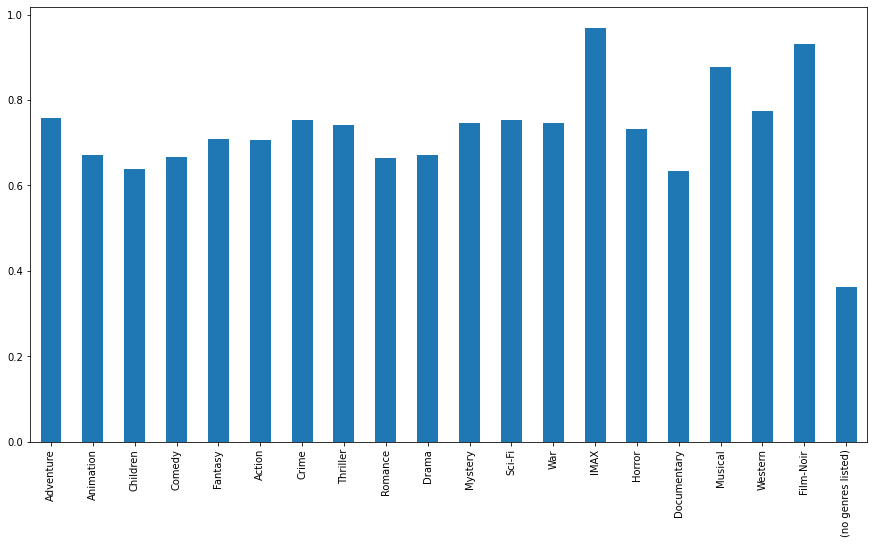

In [0]:
s1.plot.bar(figsize = (15, 8))

## **Cluster 2**

In [0]:
temp2 = xyz[xyz['Cluster'] == 1]
temp2

,userId,Cluster
2,187,1
20,939,1
37,1831,1
47,2054,1
48,2165,1
...,...,...
4138,160858,1
4143,161047,1
4149,161342,1
4152,161544,1


In [0]:
cluster_2 = pd.merge(ratings, temp2, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_2 = pd.merge(cluster_2, movies, on = 'movieId')

In [0]:
cluster_2.drop(columns = ['Cluster', 'timestamp', 'userId'], inplace = True)

In [0]:
cluster_2['genres']=cluster_2['genres'].apply(lambda x: x.split('|'))

In [0]:
cluster_2.drop_duplicates(subset = 'movieId', keep = 'first', inplace = True)

In [0]:
import itertools
genres_2 = list(itertools.chain(*cluster_2.genres.tolist()))

In [0]:
myDictionary2 = collections.Counter(genres_2)

In [0]:
for key in myDictionary2:
  myDictionary2[key] = float(myDictionary2[key])/float(genres_dict[key])

In [0]:
bars2 = list(myDictionary2.keys())

In [0]:
height2 = list(myDictionary2.values())

In [0]:
s2 = pd.Series(data = height2, index = bars2)

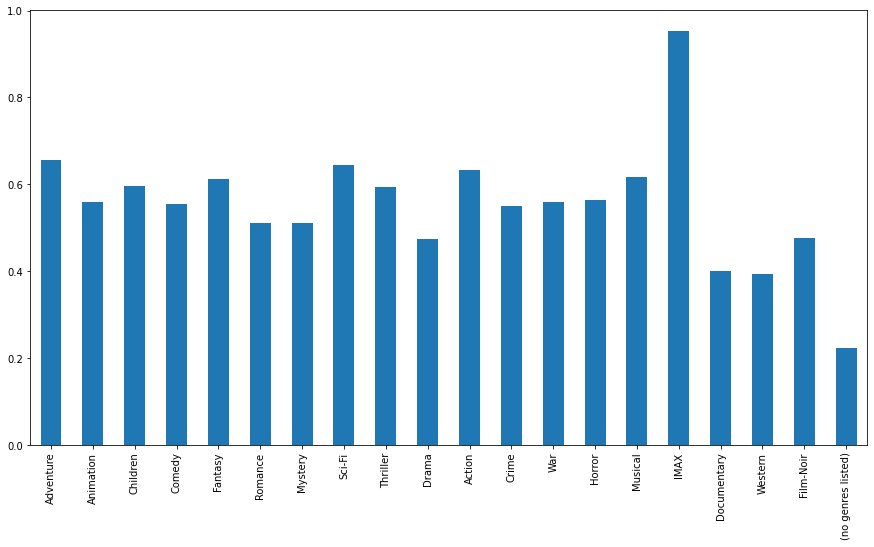

In [0]:
s2.plot.bar(figsize = (15, 8))

## **Cluster 3**

In [0]:
temp3 = xyz[xyz['Cluster'] == 2]
temp3

,userId,Cluster
8,426,2
13,741,2
14,803,2
23,1203,2
24,1208,2
...,...,...
4150,161378,2
4157,161841,2
4158,161873,2
4161,162067,2


In [0]:
cluster_3 = pd.merge(ratings, temp3, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_3 = pd.merge(cluster_3, movies, on = 'movieId')

In [0]:
cluster_3.drop(columns = ['Cluster', 'timestamp', 'userId'], inplace = True)

In [0]:
cluster_3['genres']=cluster_3['genres'].apply(lambda x: x.split('|'))

In [0]:
cluster_3.drop_duplicates(subset = 'movieId', keep = 'first', inplace = True)

In [0]:
import itertools
genres_3 = list(itertools.chain(*cluster_3.genres.tolist()))

In [0]:
myDictionary3 = collections.Counter(genres_3)

In [0]:
for key in myDictionary3:
  myDictionary3[key] = float(myDictionary3[key])/float(genres_dict[key])

In [0]:
bars3 = list(myDictionary3.keys())

In [0]:
height3 = list(myDictionary3.values())

In [0]:
s3 = pd.Series(data = height3, index = bars3)

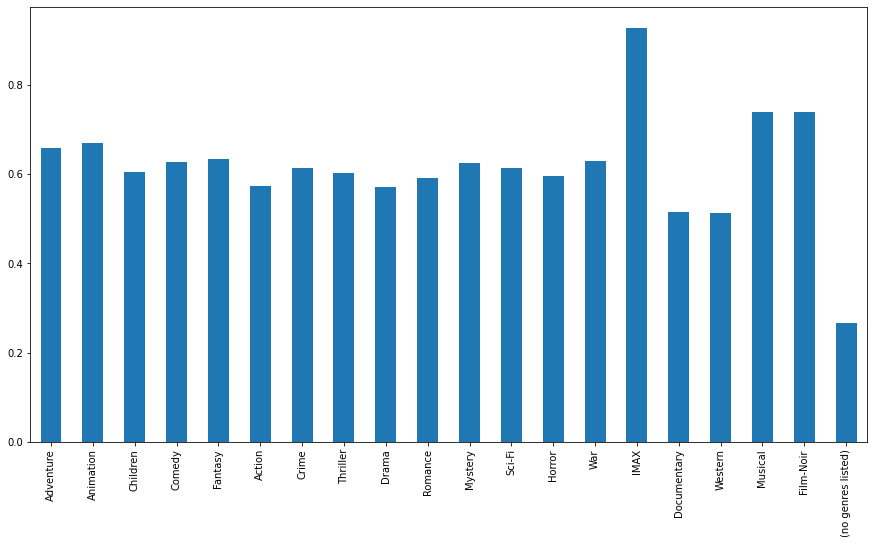

In [0]:
s3.plot.bar(figsize = (15, 8))

## **Cluster 4**

In [0]:
temp4 = xyz[xyz['Cluster'] == 3]
temp4

,userId,Cluster
1,19,3
3,284,3
4,357,3
5,368,3
7,416,3
...,...,...
4160,162055,3
4165,162326,3
4168,162390,3
4170,162482,3


In [0]:
cluster_4 = pd.merge(ratings, temp4, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_4 = pd.merge(cluster_4, movies, on = 'movieId')

In [0]:
cluster_4.drop(columns = ['Cluster', 'timestamp', 'userId'], inplace = True)

In [0]:
cluster_4['genres']=cluster_4['genres'].apply(lambda x: x.split('|'))

In [0]:
cluster_4.drop_duplicates(subset = 'movieId', keep = 'first', inplace = True)

In [0]:
import itertools
genres_4 = list(itertools.chain(*cluster_4.genres.tolist()))

In [0]:
myDictionary4 = collections.Counter(genres_4)

In [0]:
for key in myDictionary4:
  myDictionary4[key] = float(myDictionary4[key])/float(genres_dict[key])

In [0]:
bars4 = list(myDictionary4.keys())

In [0]:
height4 = list(myDictionary4.values())

In [0]:
s4 = pd.Series(data = height4, index = bars4)

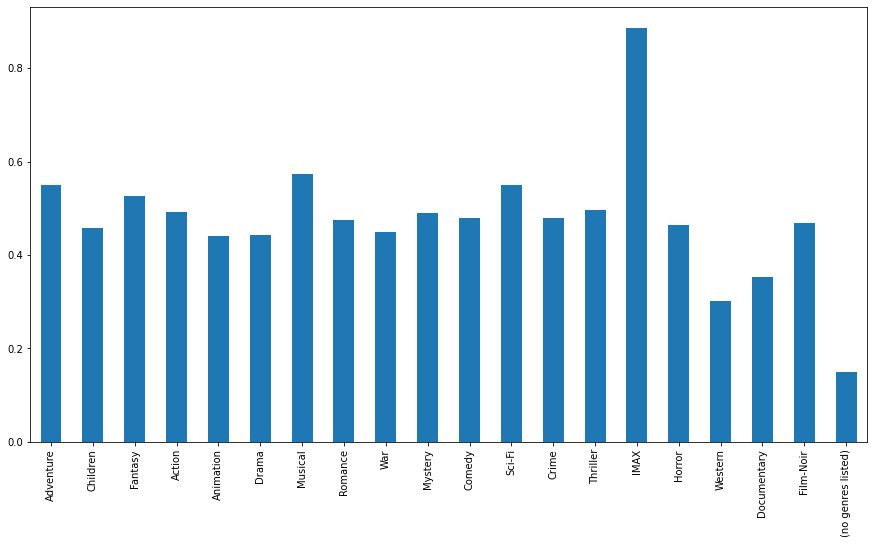

In [0]:
s4.plot.bar(figsize = (15, 8))

## **Cluster 5**

In [0]:
temp5 = xyz[xyz['Cluster'] == 4]
temp5

,userId,Cluster
1889,72315,4


In [0]:
cluster_5 = pd.merge(ratings, temp5, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_5 = pd.merge(cluster_5, movies, on = 'movieId')

In [0]:
cluster_5.drop(columns = ['Cluster', 'timestamp', 'userId'], inplace = True)

In [0]:
cluster_5['genres']=cluster_5['genres'].apply(lambda x: x.split('|'))

In [0]:
cluster_5.drop_duplicates(subset = 'movieId', keep = 'first', inplace = True)

In [0]:
import itertools
genres_5 = list(itertools.chain(*cluster_5.genres.tolist()))

In [0]:
myDictionary5= collections.Counter(genres_5)

In [0]:
for key in myDictionary5:
  myDictionary5[key] = float(myDictionary5[key])/float(genres_dict[key])

In [0]:
bars5 = list(myDictionary5.keys())

In [0]:
height5 = list(myDictionary5.values())

In [0]:
s5 = pd.Series(data = height5, index = bars5)

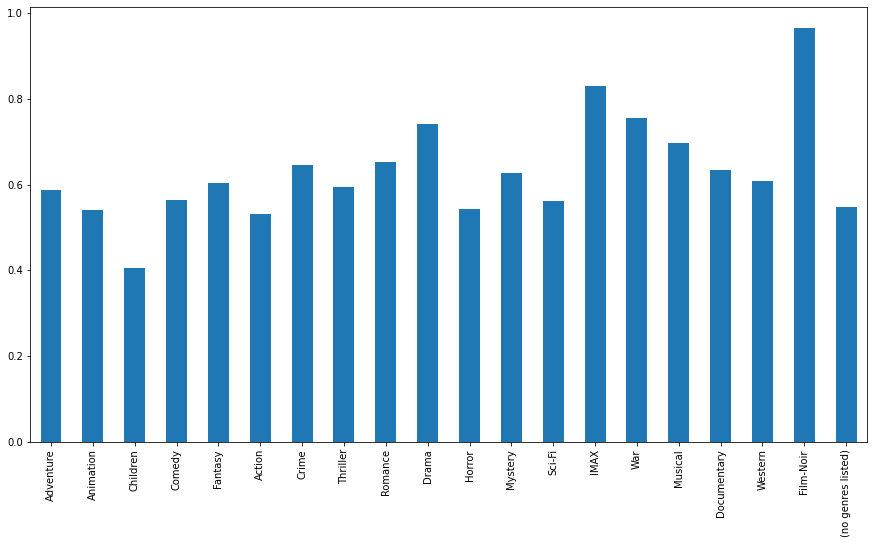

In [0]:
s5.plot.bar(figsize = (15, 8))

## **Cluster 6**

In [0]:
temp6 = xyz[xyz['Cluster'] == 5]
temp6

,userId,Cluster
0,3,5
6,402,5
9,494,5
11,647,5
12,653,5
...,...,...
4164,162297,5
4166,162334,5
4169,162467,5
4172,162512,5


In [0]:
cluster_6 = pd.merge(ratings, temp6, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_6 = pd.merge(cluster_6, movies, on = 'movieId')

In [0]:
cluster_6.drop(columns = ['Cluster', 'timestamp', 'userId'], inplace = True)

In [0]:
cluster_6['genres']=cluster_6['genres'].apply(lambda x: x.split('|'))

In [0]:
cluster_6.drop_duplicates(subset = 'movieId', keep = 'first', inplace = True)

In [0]:
import itertools
genres_6 = list(itertools.chain(*cluster_6.genres.tolist()))

In [0]:
myDictionary6 = collections.Counter(genres_6)

In [0]:
for key in myDictionary6:
  myDictionary6[key] = float(myDictionary6[key])/float(genres_dict[key])

In [0]:
bars6 = list(myDictionary6.keys())

In [0]:
height6 = list(myDictionary6.values())

In [0]:
s6 = pd.Series(data = height6, index = bars6)

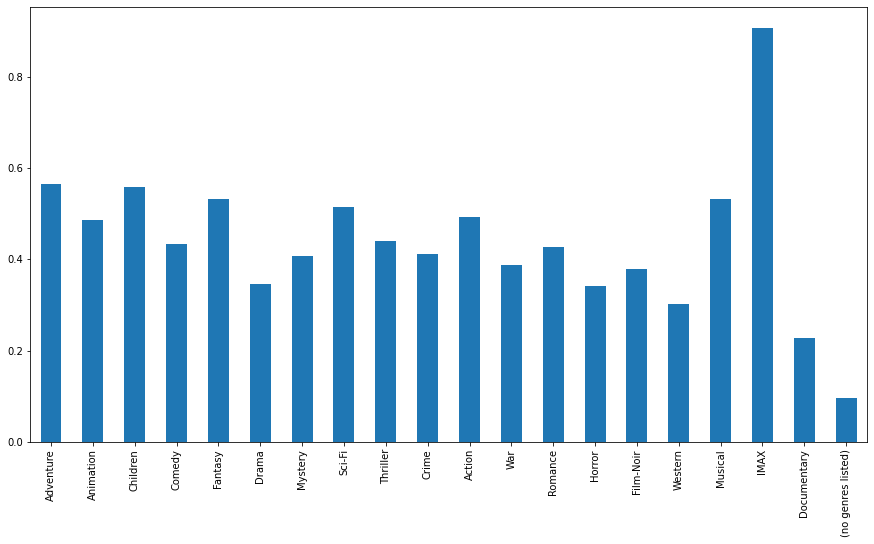

In [0]:
s6.plot.bar(figsize = (15, 8))

## **Density-based spatial clustering of applications with noise (DBSCAN)**

In [0]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [0]:
db = DBSCAN(eps= 100, algorithm='ball_tree', metric='minkowski', p=2, n_jobs = -1)

In [0]:
arr = db.fit_predict(X)

In [0]:
labels = db.labels_

In [0]:
import collections
len(collections.Counter(labels))

2

In [0]:
collections.Counter(labels)

Counter({-1: 1026, 0: 3149})

In [0]:
grid_search_dbscan = {}

In [0]:
def dbscan_grid_search(X_data, eps_space):
  for eps_val in eps_space:
    dbscan_grid = DBSCAN(eps = eps_val, n_jobs = -1).fit(X_data)
    cluster_count = collections.Counter(dbscan_grid.labels_)
    grid_search_dbscan[eps_val] = cluster_count
    print(eps_val)

In [0]:
dbscan_grid_search(X_data = X,eps_space = [150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250])

150
160
170
180
190
200
210
220
230
240
250


In [0]:
grid_search_dbscan

{150: Counter({-1: 119, 0: 4056}),
 160: Counter({-1: 85, 0: 4090}),
 170: Counter({-1: 54, 0: 4121}),
 180: Counter({-1: 28, 0: 4147}),
 190: Counter({-1: 18, 0: 4157}),
 200: Counter({-1: 12, 0: 4163}),
 210: Counter({-1: 7, 0: 4168}),
 220: Counter({-1: 5, 0: 4170}),
 230: Counter({-1: 4, 0: 4171}),
 240: Counter({-1: 3, 0: 4172}),
 250: Counter({-1: 2, 0: 4173})}

## **Elbow Method**

In [0]:
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist

In [0]:
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    print(k)

1
2
3
4
5
6
7
8
9


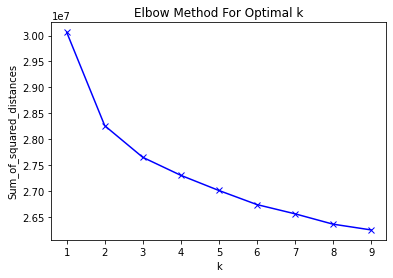

In [0]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## ***MOVIE GENRE MATRIX***

In [0]:
genres = []
for i in movies.index:
    genres.extend(movies['genres'][i].split('|'))

In [0]:
genres = list(set(genres))
genres.remove('(no genres listed)')
len(genres)

19

In [0]:
movies_temp = movies.copy()

In [0]:
movies_temp = movies_temp.set_index('movieId')

In [0]:
movie_genre = pd.DataFrame(columns = genres, index = movie_ids)

In [0]:
movie_genre[genres] = 0.0

In [0]:
for i in movie_ids:
    for j in movies_temp['genres'][i].split('|'):
        try:
            movie_genre[j][i] = 1
        except KeyError:
            pass

In [0]:
movie_genre

,Sci-Fi,Western,Animation,Thriller,Adventure,Fantasy,Crime,Horror,War,Film-Noir,Comedy,Drama,Musical,IMAX,Documentary,Action,Mystery,Romance,Children
296,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
1217,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1653,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4308,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0
5952,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181023,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
144148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
190577,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
206515,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## ***Timestamp***

In [0]:
total.describe()['timestamp']['75%']

1454200478.0

In [0]:
test_75 = total[total['timestamp'] <= 1454200478.0]

In [0]:
test_25 = total[total['timestamp'] > 1454200478.0]

In [0]:
len(test_75['userId'].unique())

4106

In [0]:
len(test_25['userId'].unique())

4175

In [0]:
common = list(set(test_75['userId'].unique()).intersection(set(test_25['userId'].unique())))

In [0]:
common

In [0]:
test_75

,userId,movieId,rating,timestamp,title,genres
1,3,296,5.0,1439474476,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
90,187,296,4.5,1277374442,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
140,284,296,4.5,1431924674,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
173,357,296,3.5,1367156671,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
179,368,296,5.0,1402798200,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
...,...,...,...,...,...,...
25000058,162067,114365,2.5,1445788103,Wer's glaubt wird selig (2012),[Comedy]
25000059,162067,150610,2.5,1452554148,Der böse Onkel (2013),"[Comedy, Drama]"
25000074,162271,92648,3.0,1327978630,BookWars (2000),"[Comedy, Crime, Documentary]"
25000075,162271,92946,1.0,1329627154,"Souler Opposite, The (1998)","[Comedy, Romance]"


## **Predicting From TimeStamp**

In [0]:
test75_groupby = pd.DataFrame(test_75.groupby(['userId', 'timestamp'])['movieId'].unique())

In [0]:
identify = pd.DataFrame(movie_genre.index.tolist())
identify = identify.rename(columns = {0 : 'movieId'})

In [0]:
identify[identify.index.isin([12404, 18238, 24501, 38769, 38770])].movieId.tolist()

[6237, 73416, 139614, 203823, 49739]

In [0]:
user_movie_pred2 = {}
for i in common:
    user_movie_pred2[i] = []

In [0]:
count_user = 1
for user in common:
    num = 5
    print(count_user)
    count_user += 1
    count = 0
    try:
      while len(user_movie_pred2[user]) != 15:
          movie_id = (test75_groupby.loc[user])[::-1].iloc[count]['movieId']
          for i in movie_id:
              array = (cosine_similarity(np.array(movie_genre.loc[i]).reshape(1, 19), movie_genre))[0].argsort()[-num:][::-1]
              user_movie_pred2[user].extend(identify[identify.index.isin(array.tolist())].movieId.tolist())
              if num > 1:
                  num -= 1
          user_movie_pred2[user] = list(set(user_movie_pred2[user]).difference(set(test_75[test_75['userId'] == user].movieId.tolist())))
          count += 1
    except IndexError:
      pass

In [0]:
for user in user_movie_pred2:
    match = set(user_movie_pred2[user]).intersection(set(test_25[test_25['userId'] == user].movieId.tolist()))
    if len(match) > 0:
      print(user)
      print(list(match), len(match))

3
[81834] 1
81957
[26603] 1
106550
[57368, 103883] 2
98363
[68358] 1
16465
[76093] 1
147539
[105504] 1
122968
[91535] 1
90234
[4370] 1
98430
[118696] 1
57494
[52722] 1
73911
[68358] 1
106706
[6709] 1
82142
[139644] 1
41185
[90249] 1
49403
[2328] 1
57595
[103042] 1
24832
[6564] 1
98564
[98243] 1
24859
[8361] 1
8476
[57368, 202799] 2
139567
[72605, 106487] 2
90441
[103042, 165667, 4978, 151695] 4
65939
[103883, 122886, 44191] 3
74130
[54736, 6537, 104841] 3
57813
[162356] 1
147935
[68358] 1
494
[104841] 1
41527
[6537] 1
98873
[96520, 139644, 150] 3
90691
[72167] 1
57925
[103042, 68358] 2
49735
[86880] 1
33404
[110134] 1
647
[68358] 1
148115
[49200] 1
90785
[190339, 168612, 133988, 149830, 185031, 81834, 192307, 173145] 8
41657
[6537] 1
156346
[6541] 1
66244
[101025] 1
123590
[110553, 102445] 2
49867
[595] 1
41686
[118696, 60760, 4006] 3
8932
[4370] 1
66315
[81229, 72167] 2
82730
[111759] 1
99117
[118696, 98809, 8368] 3
156480
[86880, 103042, 104841, 81834, 95510] 5
148294
[1566] 1
33610


In [0]:
count = 0
for i in user_movie_pred2:
  if len(user_movie_pred2[i]) > 0:
    count += 1
print(count)

4106


## **Predicting From Clusters**

In [0]:
test75_matrix = test_75.pivot_table(index='userId',columns='movieId',values='rating')

In [0]:
test75_matrix = test75_matrix.fillna(0.0)

In [0]:
X = test75_matrix.iloc[:, :].values

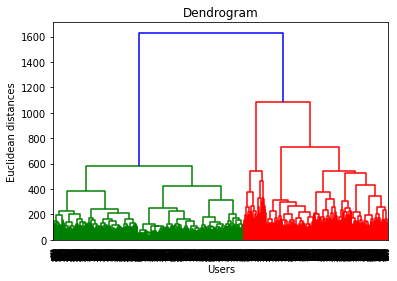

In [0]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Users')
plt.ylabel('Euclidean distances')
plt.show()

In [0]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc = hc.fit_predict(X)

In [0]:
y_hc

array([3, 0, 1, ..., 0, 2, 3])

In [0]:
import collections
collections.Counter(y_hc)

Counter({0: 2340, 1: 913, 2: 262, 3: 591})

In [0]:
xyz = pd.concat([pd.DataFrame(test75_matrix.index.tolist(), columns = ['userId']), pd.DataFrame(y_hc, columns = ['Cluster'])], axis = 1)

In [0]:
xyz

,userId,Cluster
0,3,3
1,19,0
2,187,1
3,284,0
4,357,0
...,...,...
4101,162482,0
4102,162498,0
4103,162512,0
4104,162516,2


In [0]:
ratings = pd.merge(ratings, ratings.groupby('movieId', as_index = False)['rating'].count(), on = 'movieId')

In [0]:
ratings = ratings.rename(columns = {'rating_x': 'rating', 'rating_y': 'count_num'})

In [0]:
gc.collect()

11

## **Cluster 1**

In [0]:
temp1 = xyz[xyz['Cluster'] == 0]
temp1

,userId,Cluster
1,19,0
3,284,0
4,357,0
5,368,0
6,402,0
...,...,...
4099,162390,0
4100,162467,0
4101,162482,0
4102,162498,0


In [0]:
cluster_1 = pd.merge(ratings, temp1, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_1.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_1=pd.DataFrame(cluster_1.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_1 = cluster_1.reset_index()

In [0]:
cluster_1

,movieId,count_num,count_rate
0,1,57309,3.686062
1,2,24228,3.133504
2,3,11804,2.976190
3,4,2523,2.333333
4,5,11714,2.559028
...,...,...,...
29991,209123,1,4.000000
29992,209129,1,4.500000
29993,209131,1,3.500000
29994,209159,1,3.000000


## **Cluster 2**

In [0]:
temp2 = xyz[xyz['Cluster'] == 1]
temp2

,userId,Cluster
2,187,1
8,426,1
12,653,1
20,939,1
22,1203,1
...,...,...
4069,160858,1
4074,161047,1
4081,161378,1
4090,161928,1


In [0]:
cluster_2 = pd.merge(ratings, temp2, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_2.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_2=pd.DataFrame(cluster_2.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_2 = cluster_2.reset_index()

In [0]:
cluster_2

,movieId,count_num,count_rate
0,1,57309,3.826467
1,2,24228,3.014555
2,3,11804,2.858696
3,4,2523,2.390625
4,5,11714,2.713918
...,...,...,...
32507,208889,2,3.000000
32508,208939,8,4.000000
32509,208941,1,3.000000
32510,209069,1,3.000000


## **Cluster 3**

In [0]:
temp3 = xyz[xyz['Cluster'] == 2]
temp3

,userId,Cluster
14,803,2
16,847,2
33,1748,2
36,1831,2
44,1977,2
...,...,...
4047,159816,2
4056,160219,2
4062,160540,2
4094,162271,2


In [0]:
cluster_3 = pd.merge(ratings, temp3, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_3.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_3=pd.DataFrame(cluster_3.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_3 = cluster_3.reset_index()

In [0]:
cluster_3

,movieId,count_num,count_rate
0,1,57309,4.128099
1,2,24228,3.036810
2,3,11804,2.915842
3,4,2523,2.546512
4,5,11714,2.813131
...,...,...,...
42186,208939,8,4.000000
42187,209049,1,4.500000
42188,209051,1,3.500000
42189,209121,1,4.000000


## **Cluster 4**

In [0]:
temp4 = xyz[xyz['Cluster'] == 3]
temp4

,userId,Cluster
0,3,3
15,815,3
25,1232,3
39,1881,3
50,2375,3
...,...,...
4080,161342,3
4084,161560,3
4096,162326,3
4097,162334,3


In [0]:
cluster_4 = pd.merge(ratings, temp4, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_4.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_4=pd.DataFrame(cluster_4.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_4 = cluster_4.reset_index()

In [0]:
cluster_4

,movieId,count_num,count_rate
0,1,57309,3.882474
1,2,24228,3.332845
2,3,11804,3.400000
3,4,2523,1.000000
4,5,11714,2.861111
...,...,...,...
17948,208905,1,2.000000
17949,208907,1,1.000000
17950,208909,1,2.000000
17951,208911,1,4.000000


# **Cross Validation & Conclusion**

In [0]:
test_25 = test_25[test_25['userId'].isin(xyz.userId.tolist())]

In [0]:
test_25 = pd.DataFrame(test_25.groupby(['userId'])['movieId'].unique())

In [0]:
test_25 = test_25.reset_index()

In [0]:
test_25 = pd.merge(test_25, xyz, on = 'userId')

In [0]:
mean_dict = {}
for k in range(2000, 4501, 200):
  for j in range(2000, 3001, 100):
    cluster_1_movies = (cluster_1[cluster_1['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    cluster_2_movies = (cluster_2[cluster_2['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    cluster_3_movies = (cluster_3[cluster_3['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    cluster_4_movies = (cluster_4[cluster_4['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    movie_dict = {0 : cluster_1_movies, 1 : cluster_2_movies, 2 : cluster_3_movies, 3 : cluster_4_movies}
    test_25['moviesPredicted'] = test_25['Cluster'].apply(lambda x : movie_dict[x])
    test_25['correctPredictions'] = 0
    test_25['recall'] = 0.0
    for i in test_25.index:
      test_25.loc[i, 'correctPredictions'] = len(set(test_25.iloc[i]['movieId']).intersection(set(test_25.iloc[i]['moviesPredicted'])))
    for i in test_25.index:
      test_25.loc[i, 'recall'] = round(float(test_25.iloc[i]['correctPredictions'])/float(len(test_25.iloc[i]['movieId'])), 2)
    mean_dict[(k, j)] = test_25.describe()['recall']['mean']

In [0]:
mean_dict

{(2000, 2000): 0.5985776911836328,
 (2000, 2100): 0.6132001948368235,
 (2000, 2200): 0.6235289819775947,
 (2000, 2300): 0.6349342425718466,
 (2000, 2400): 0.6430418899171939,
 (2000, 2500): 0.6445908426692645,
 (2000, 2600): 0.6445908426692645,
 (2000, 2700): 0.6445908426692645,
 (2000, 2800): 0.6445908426692645,
 (2000, 2900): 0.6445908426692645,
 (2000, 3000): 0.6445908426692645,
 (2200, 2000): 0.6003336580613732,
 (2200, 2100): 0.6118631271310283,
 (2200, 2200): 0.6225085241110572,
 (2200, 2300): 0.6292425718460791,
 (2200, 2400): 0.6292425718460791,
 (2200, 2500): 0.6292425718460791,
 (2200, 2600): 0.6292425718460791,
 (2200, 2700): 0.6292425718460791,
 (2200, 2800): 0.6292425718460791,
 (2200, 2900): 0.6292425718460791,
 (2200, 3000): 0.6292425718460791,
 (2400, 2000): 0.5983999025815878,
 (2400, 2100): 0.6092985874330248,
 (2400, 2200): 0.6146809547004375,
 (2400, 2300): 0.6146809547004375,
 (2400, 2400): 0.6146809547004375,
 (2400, 2500): 0.6146809547004375,
 (2400, 2600): 0.614

In [0]:
  cluster_1_movies = (cluster_1[cluster_1['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  cluster_2_movies = (cluster_2[cluster_2['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  cluster_3_movies = (cluster_3[cluster_3['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  cluster_4_movies = (cluster_4[cluster_4['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  movie_dict = {0 : cluster_1_movies, 1 : cluster_2_movies, 2 : cluster_3_movies, 3 : cluster_4_movies}
  test_25['moviesPredicted'] = test_25['Cluster'].apply(lambda x : movie_dict[x])
  test_25['correctPredictions'] = 0
  test_25['recall'] = 0.0
  for i in test_25.index:
    test_25.loc[i, 'correctPredictions'] = len(set(test_25.iloc[i]['movieId']).intersection(set(test_25.iloc[i]['moviesPredicted'])))
  for i in test_25.index:
    test_25.loc[i, 'recall'] = round(float(test_25.iloc[i]['correctPredictions'])/float(len(test_25.iloc[i]['movieId'])), 2)

In [0]:
test_25

,userId,movieId,Cluster,moviesPredicted,correctPredictions,recall
0,3,"[6711, 8360, 3948, 5574, 6879, 7143, 29, 111, ...",3,"[2111, 663, 318, 2677, 2959, 2571, 58559, 1694...",165,0.72
1,19,"[296, 1722, 1907, 2273, 2294, 293, 3328, 31878...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",20,0.42
2,187,"[1909, 109487, 122886, 134130, 152081, 165483,...",1,"[318, 858, 1203, 296, 1221, 2959, 1201, 1193, ...",5,0.71
3,284,"[3949, 7361, 8360, 8873, 527, 1080, 1201, 1584...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",168,0.84
4,357,"[1485, 3300, 4992, 45672, 48780, 51255, 53121,...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",56,0.49
...,...,...,...,...,...,...
4101,162482,"[135143, 139385, 148626, 158966, 164179, 16652...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",9,0.60
4102,162498,"[63876, 1104, 87522, 72949, 90592]",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",2,0.40
4103,162512,"[4299, 40815, 1732, 4027, 4344, 4369, 4816, 54...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",60,0.91
4104,162516,"[6539, 7323, 54648, 59615, 60074, 87430, 89753...",2,"[858, 1221, 912, 318, 1198, 527, 1203, 904, 26...",87,0.36


In [0]:
test_25.describe()

,userId,Cluster,correctPredictions,recall
count,4106.000000,4106.000000,4106.000000,4106.000000
mean,80964.650024,0.781783,96.834145,0.644591
std,46507.980450,1.078014,131.581206,0.233974
min,3.000000,0.000000,0.000000,0.000000
25%,40769.000000,0.000000,21.000000,0.480000
50%,80243.000000,0.000000,55.000000,0.670000
75%,121489.500000,1.000000,121.000000,0.830000
max,162521.000000,3.000000,1603.000000,1.000000


In [0]:
test_25[['userId', 'recall']]

,userId,recall
0,3,0.72
1,19,0.42
2,187,0.71
3,284,0.84
4,357,0.49
...,...,...
4101,162482,0.60
4102,162498,0.40
4103,162512,0.91
4104,162516,0.36


In [0]:
test_25[['userId', 'recall']].to_csv("/content/drive/My Drive/DS Project 20M/predictions1.csv", index = False)

# **Recommending Similar Movies**

In [0]:
moviemat = total.pivot_table(index='userId',columns='title',values='rating')

In [0]:
moviemat = moviemat.fillna(0.0)

In [0]:
ratings_movies = pd.DataFrame(total.groupby('title')['rating'].mean())

In [0]:
ratings_movies['num of ratings'] = pd.DataFrame(total.groupby('title')['rating'].count())

In [14]:
ratings_movies.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
"Matrix, The (1999)",4.183385,3858
Forrest Gump (1994),3.967240,3663
Inception (2010),4.062910,3656
"Lord of the Rings: The Fellowship of the Ring, The (2001)",4.010066,3626
Fight Club (1999),4.227715,3601
Pulp Fiction (1994),4.202361,3600
"Shawshank Redemption, The (1994)",4.352201,3498
"Dark Knight, The (2008)",4.079994,3469
"Lord of the Rings: The Two Towers, The (2002)",3.989011,3458


In [0]:
MOVIES = (ratings_movies.sort_values('num of ratings',ascending=False).head(10)).drop(columns = ['rating', 'num of ratings'])

In [0]:
lords_user_ratings = moviemat['Lord of the Rings: The Fellowship of the Ring, The (2001)']
the_matrix_user_ratings = moviemat['Dark Knight, The (2008)']

In [0]:
similar_to_lords = moviemat.corrwith(lords_user_ratings)
similar_to_the_matrix = moviemat.corrwith(the_matrix_user_ratings)

In [0]:
corr_lords = pd.DataFrame(similar_to_lords,columns=['Correlation'])
corr_lords.dropna(inplace=True)
corr_lords = corr_lords.join(ratings_movies['num of ratings'])
corr_lords[corr_lords['num of ratings']>100].sort_values('Correlation',ascending=False).head(6)

,Correlation,num of ratings
title,,
"Lord of the Rings: The Fellowship of the Ring, The (2001)",1.000000,3626
"Lord of the Rings: The Two Towers, The (2002)",0.856779,3458
"Lord of the Rings: The Return of the King, The (2003)",0.832795,3444
"Hobbit: An Unexpected Journey, The (2012)",0.438066,2073
Star Wars: Episode VI - Return of the Jedi (1983),0.390718,2919
Pirates of the Caribbean: The Curse of the Black Pearl (2003),0.386866,3237


In [0]:
corr_the_matrix = pd.DataFrame(similar_to_the_matrix,columns=['Correlation'])
corr_the_matrix.dropna(inplace=True)
corr_the_matrix = corr_the_matrix.join(ratings_movies['num of ratings'])
corr_the_matrix[corr_the_matrix['num of ratings']>100].sort_values('Correlation',ascending=False).head(6)

,Correlation,num of ratings
title,,
"Dark Knight, The (2008)",1.000000,3469
"Dark Knight Rises, The (2012)",0.613081,2760
Batman Begins (2005),0.610832,3067
Iron Man (2008),0.460479,2994
Inception (2010),0.428992,3656
"Avengers, The (2012)",0.397645,2550


In [0]:
def magic_function(s):
  movie_user_ratings = moviemat[s]
  similar_to_movie = moviemat.corrwith(movie_user_ratings)
  corr_movies = pd.DataFrame(similar_to_movie,columns=['Correlation'])
  corr_movies.dropna(inplace=True)
  corr_movies = corr_movies.join(ratings_movies['num of ratings'])
  return ((corr_movies[corr_movies['num of ratings']>100].sort_values('Correlation',ascending=False)).head(6)).drop(columns = ['Correlation',	'num of ratings'])

# **MAGIC FUNCTION**

In [17]:
MOVIES

""
title
"Matrix, The (1999)"
Forrest Gump (1994)
Inception (2010)
"Lord of the Rings: The Fellowship of the Ring, The (2001)"
Fight Club (1999)
Pulp Fiction (1994)
"Shawshank Redemption, The (1994)"
"Dark Knight, The (2008)"
"Lord of the Rings: The Two Towers, The (2002)"


In [21]:
magic_function('Inception (2010)')

""
title
Inception (2010)
"Dark Knight, The (2008)"
Interstellar (2014)
"Dark Knight Rises, The (2012)"
Shutter Island (2010)
"Prestige, The (2006)"
